# OVERVIEW
1. Announcements
2. Module 1 recap
3. Linear regression continued
4. Splitting data into training and test
5. Metrics - R2 score
6. Bias-Variance tradeoff
7. Project Module


#What’s our goal for this guided project?
* Create a model to predict how much vote share an 
incumbent president will receive.   
#What are the core learning objectives that will allow us to meet that goal?
* Do train/test split.
* Use scikit-learn to fit a multiple regression model.
* Use metrics such as MAE, RMSE, and R^2 to evaluate model.


#What’s my plan for today’s project?
1. Explore our dataset (EDA) and define our problem
2. Train-test split
3. Build multiple regression model
4. Evaluate model performance using common metrics
#What else?
* Review module project
* Critical Incident Questionnaire (CIQ)


In [ ]:
# Libraries for R^2 visualization
from ipywidgets import interactive, IntSlider, FloatSlider
from math import floor, ceil
from sklearn.base import BaseEstimator, RegressorMixin

# Libraries for model building
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Library for working locally or Colab
import sys

In [ ]:
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'

# I. Wrangle Data

In [ ]:
# Sourcing the file path
filepath = DATA_PATH + 'elections/bread_peace_voting.csv'

# Creating a function to wrangle the data
def wrangle(filepath):
  
  # Columns that will be renamed for headers
  cols_name = ['Year','Party_canidate','Other_canidate','Personal_income_growth','Military_fatalities','Party_vote_share']

  # first file path source, then parse dates before indexing, then set the column names to the specification above, then drop the header row that becomes row 0
  df = pd.read_csv(filepath,index_col=['Year'],names=cols_name, header=0)

  # Drop high cardinal columns: cardinality is the number of unique values in your column.
  threshold = .75*len('Year')
  cols_to_drop = []
  for cols in df.select_dtypes('object'):
    if df[cols].nunique() > threshold:
      cols_to_drop.append(cols)

  df.drop(columns=cols_to_drop, inplace=True)

  return df

In [ ]:
df = wrangle(DATA_PATH + 'elections/bread_peace_voting.csv')

In [ ]:
df

,Personal_income_growth,Military_fatalities,Party_vote_share
Year,,,
1952,2.40,190,44.60
1956,2.89,0,57.76
1960,0.85,0,49.91
1964,4.21,1,61.34
1968,3.02,146,49.60
1972,3.62,0,61.79
1976,1.08,2,48.95
1980,-0.39,0,44.70
1984,3.86,0,59.17


* Target = Incumbent Party Vote Share

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Year                                       17 non-null     int64  
 1   Incumbent Party Candidate                  17 non-null     object 
 2   Other Candidate                            17 non-null     object 
 3   Average Recent Growth in Personal Incomes  17 non-null     float64
 4   US Military Fatalities per Million         17 non-null     int64  
 5   Incumbent Party Vote Share                 17 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 944.0+ bytes


In [ ]:
df['Incumbent Party Candidate'].value_counts()

Nixon         2
Bush, Sr.     2
Clinton       2
Stevenson     1
Carter        1
Johnson       1
Eisenhower    1
Obama         1
McCain        1
Reagan        1
Bush, Jr.     1
Gore          1
Humphrey      1
Ford          1
Name: Incumbent Party Candidate, dtype: int64

# II. Split Data

**First** we need to split our **target vector** from our **feature matrix**.

In [ ]:
# Define our feature X and target y
target = 'Party_vote_share'
y = df[target]
X = df.drop(columns=target)

**Second** we need to split our dataset into **training** and **test** sets.

Two strategies:

- Random train-test split using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Generally we use 80% of the data for training, and 20% of the data for testing.
- If you have **timeseries**, then you need to do a "cutoff" split.

In [ ]:
# Take all data before 2008 for training and test on data from 2008-2020
cutoff = 2008
mask = X.index < cutoff
X_train,y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [ ]:
X_train.shape, X_test.shape

((14, 2), (3, 2))

# III. Establish Baseline

In [ ]:
# The baseline prediction would always be the mean of the target variable used in the  TRAINING DATA.
y_pred = [y_train.mean()]*len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)

print('Incumbunt vote share: ',y_train.mean())
print('---------------------------------------------')
print('Baseline MAE: ',baseline_mae)

Incumbunt vote share:  52.46857142857142
---------------------------------------------
Baseline MAE:  4.846938775510204


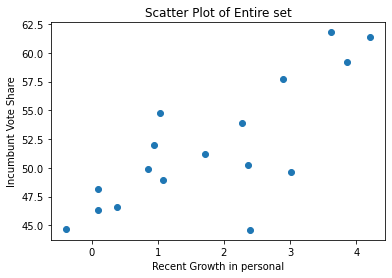

In [ ]:
# plotting the entire data
plt.scatter(X['Personal_income_growth'],y)
plt.xlabel('Recent Growth in personal')
plt.ylabel('Incumbunt Vote Share')
plt.title('Scatter Plot of Entire set')
plt.show();

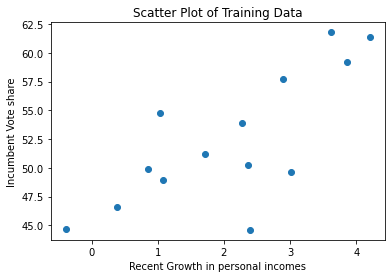

In [ ]:
# plotting the training data
plt.scatter(X_train['Personal_income_growth'],y_train)
plt.xlabel('Recent Growth in personal incomes')
plt.ylabel('Incumbent Vote share')
plt.title('Scatter Plot of Training Data')
plt.show();

# IV. Build Model

In [ ]:
# Step 1: Already done the import of libaraies

# Step 2: Instantiation
model = LinearRegression()

model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# V. Check Metrics

## Mean Absolute Error

The unit of measurement is the same as the unit of measurment for your target (in this case, vote share [%]).

In [ ]:
# Predicting the y values on training and test data
y_pred_train_lr = model.predict(X_train)
y_pred_test_lr = model.predict(X_test)

# Calculating metric on the training and test data
print('Training MAE: ',mean_absolute_error(y_train, y_pred_train_lr))
print('-------------------------------------------------------------')
print('Test MAE: ',mean_absolute_error(y_test, y_pred_test_lr))

Training MAE:  1.3303221006874268
-------------------------------------------------------------
Test MAE:  1.6341722692537293


## Root Mean Squared Error

The unit of measurement is the same as the unit of measurment for your target (in this case, vote share [%]).

In [ ]:
# Calculating the RMSE for training and test data
print('Training RMSE: ', mean_squared_error(y_train,y_pred_train_lr,squared=False))
print('-------------------------------------------------------------')
print('Test RMSE: ', mean_squared_error(y_test,y_pred_test_lr,squared=False))

Training RMSE:  1.9823427386821593
-------------------------------------------------------------
Test RMSE:  1.8613616351898397


## $R^2$ Score

TL;DR: Usually ranges between 0 (bad) and 1 (good).

In [ ]:
class BruteForceRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, m=0, b=0):
        self.m = m
        self.b = b
        self.mean = 0
        
    def fit(self, X, y):
        self.mean = np.mean(y)
        return self
    
    def predict(self, X, return_mean=True):
        if return_mean:
            return [self.mean] * len(X)
        else:
            return X * self.m + self.b

def plot(slope, intercept):
    # Assign data to variables
    x = df['Personal_income_growth']
    y = df['Party_vote_share']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    
    # Set ax limits
    mar = 0.2
    x_lim = floor(x.min() - x.min()*mar), ceil(x.max() + x.min()*mar)
    y_lim = floor(y.min() - y.min()*mar), ceil(y.max() + y.min()*mar)
    
    # Instantiate and train model
    bfr = BruteForceRegressor(slope, intercept)
    bfr.fit(x, y)
    
    # ax1   
    ## Plot data
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    ax1.scatter(x, y)
    
    ## Plot base model
    ax1.axhline(bfr.mean, color='orange', label='baseline model')
    
    ## Plot residual lines
    y_base_pred = bfr.predict(x)
    ss_base = mean_squared_error(y, y_base_pred) * len(y)
    for x_i, y_i, yp_i in zip(x, y, y_base_pred):
        ax1.plot([x_i, x_i], [y_i, yp_i], 
                 color='gray', linestyle='--', alpha=0.75)
    
    ## Formatting
    ax1.legend()
    ax1.set_title(f'Sum of Squares: {np.round(ss_base, 2)}')
    ax1.set_xlabel('Growth in Personal Incomes')
    ax1.set_ylabel('Incumbent Party Vote Share [%]')

    # ax2

    ax2.set_xlim(x_lim)
    ax2.set_ylim(y_lim)
    ## Plot data
    ax2.scatter(x, y)
    
    ## Plot model
    x_model = np.linspace(*ax2.get_xlim(), 10)
    y_model = bfr.predict(x_model, return_mean=False)
    ax2.plot(x_model, y_model, color='green', label='our model')
    for x_coord, y_coord in zip(x, y):
        ax2.plot([x_coord, x_coord], [y_coord, x_coord * slope + intercept], 
                 color='gray', linestyle='--', alpha=0.75)   
    
    ss_ours = mean_squared_error(y, bfr.predict(x, return_mean=False)) * len(y)
    
    ## Formatting
    ax2.legend()
    ax2.set_title(f'Sum of Squares: {np.round(ss_ours, 2)}')
    ax2.set_xlabel('Growth in Personal Incomes')
    ax2.set_ylabel('Incumbent Party Vote Share [%]')

y = df['Party_vote_share']
slope_slider = FloatSlider(min=-5, max=5, step=0.5, value=0)
intercept_slider = FloatSlider(min=int(y.min()), max=y.max(), step=2, value=y.mean())
    
interactive(plot, slope=slope_slider, intercept=intercept_slider)

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0, step=0.5), FloatSlider(va…

In [ ]:
# R2 score = 1 - (model/baseline)
# R2 score = 1 - (485/485) = 0
# R2 score = 1 -(0/485) = 1

1 - (1526/485)

-2.1463917525773195

In [ ]:
# Calculating r2 for our training and test data
print('Training R^2 Score:', model.score(X_train, y_train))
print('Test R^2 Score:', model.score(X_test, y_test))

Training R^2 Score: 0.8739958896016927
Test R^2 Score: 0.3792995526663848


# VI. Communicate Results

**Challenge:** How can we find the coefficients and intercept for our `model`?

In [ ]:
model.coef_

array([ 3.59004735, -0.05315709])

In [ ]:
print('The coefficient for income is:', model.coef_[0])
print('The coefficient for fatalities is:', model.coef_[1])

The coefficient for income is: 3.5900473494560536
The coefficient for fatalities is: -0.05315709351049324


In [ ]:
model.intercept_

46.25489966153873

In [ ]:
print('The interecept of  for fatalities is:', model.coef_[1])

The interecept of  for fatalities is: -0.05315709351049324
